# Exploring Prophet Library

Prophet is an open source library for Python and R developed by Facebook. It uses sklearn to operate and it is designed to make time series analysis simple, easy to interpret, and maintain robust outputs. It is also less computationally expensive and runs much faster than other algorithms. This makes the library appealing for quick and easy but accurate predictions in all sorts of applications. I'll be diving in to the basics of how the library works so it can be used in practice.

### How It Works
Prophet is built off of a fairly simple equation. Each part is explained below.

#### y(t) = c(t) + s(t) + h(t) + x(t) + E
- y: predictor variable
- t: time
- c: trend, overall direction, piecewise (linear with changepoints) or logistic growth.
- s: seasonal affects, recurring patterns found at regular intervals.
- h: holiday affects, domain specific recurring patterns surrounding holidays.
- x: external regressors, accounts for factors outside the time series that may affect y.
- E: error, residuals resulting from noise or patterns not captured in the other parts.


### Getting Started 
Prophet was built with ease of use in mind, its not difficult to get started. There are a few rules to follow but past that its straightforward.
- Prophet requires a date column formatted as YYYY-MM-DD.
- This column must be called 'ds' for the Prophet object to recognize it.
- The predictor variable column must be called 'y'.
- Other columns/regressors can be added to the data frame using the add_regressor() function. We won't do this in our example to keep it straightfoward. 

In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns

# import data
df = pd.read_csv("car_sales.csv")

# rename for compatibility
df.rename(columns={"Date": "ds"}, inplace=True) 
df.rename(columns={"Price ($)": "y"}, inplace=True)

# drop columns we won't use in this demo
df = df[["ds", "y"]]

# verify
df.head()


c:\Users\jamie\miniconda3\envs\blog2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,ds,y
0,1/2/2022,26000
1,1/2/2022,19000
2,1/2/2022,31500
3,1/2/2022,14000
4,1/2/2022,24500


In [7]:
# convert to datetime
df['ds'] = pd.to_datetime(df['ds'], format='%m/%d/%Y')

# verify
print(df['ds'].head())
print(df['ds'].dtype)


0   2022-01-02
1   2022-01-02
2   2022-01-02
3   2022-01-02
4   2022-01-02
Name: ds, dtype: datetime64[ns]
datetime64[ns]


Prophet is sensitive to outliers so were going to check for those in 'y' before continuing. The dataset is large enough that we'll remove any outliers.

In [8]:
# pre filter max
df['y'].max()

85800

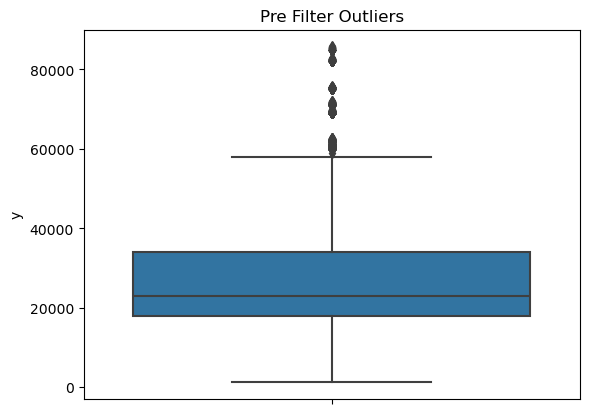

In [9]:
# check for outliers
sns.boxplot(y=df['y'])
plt.title("Pre Filter Outliers")
plt.show()

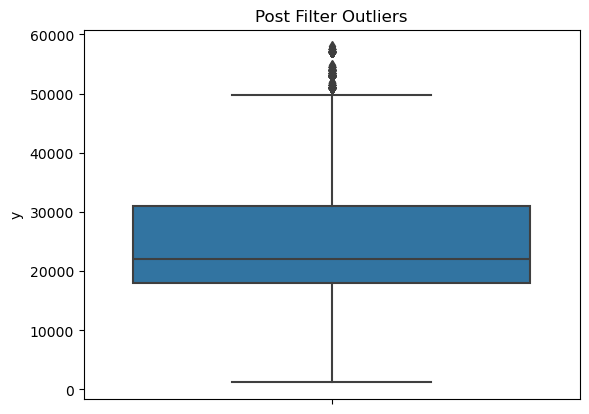

In [10]:
# set IQR boundaries
q1 = df["y"].quantile(0.25) 
q3 = df["y"].quantile(0.75)
IQR = q3 - q1

# set upper and lower bound
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

# remove the outliers
df = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)]

# reset index to account for removed rows
df.reset_index(drop=True, inplace=True)

# verify changes
sns.boxplot(y=df['y'])
plt.title("Post Filter Outliers")
plt.show()

In [11]:
# post filter max
df['y'].max()

57990

The default setting of IQR, upper bound, and lower bounds didn't catch all of the outliers but it significantly reduced them. While a car price of $57,990 is still decently high, its much more reasonable than the pre-filter max of $85,800. We'll leave post-filter outliers alone.

Now we'll create our train and test split for the modeling. For time series analysis this looks a little different than what were used to. We'll need to split our data by a certain date to accurately represent the type of predictions it would be used for in practice.

In [12]:
print(df['ds'].min()) # earliest date in data
print(df['ds'].max()) # latest date in data

2022-01-02 00:00:00
2023-12-31 00:00:00


The dataset spans about 2 years. At 730 days total, to make our train subset be 80% of the data, our split date will be August 7th, 2023. Anything beyond that point will be our test set.

In [21]:
df.index = pd.to_datetime(df.index)

split_date = "2023-08-07"
dftrain = df[df['ds'] <= split_date] # Aug. 7th and earlier
dftest = df[df['ds'] > split_date] # Aug. 8th and later

# verify split correctly
print(f"dftrain shape: {dftrain.shape}")
print(f"dftest shape: {dftest.shape}")

dftrain shape: (15518, 2)
dftest shape: (6939, 2)


In [22]:
# initialize Prophet object and fit model
model = Prophet()
model.fit(dftrain)

11:46:29 - cmdstanpy - INFO - Chain [1] start processing
11:46:31 - cmdstanpy - INFO - Chain [1] done processing


The make_future_dataframe() function is what allows us to set how far ahead our analysis will go. This creates a seperate data frame for our predictions.

In [ ]:
# make predictions
future = model.make_future_dataframe(periods=20, freq='ME') # periods selects how far out the forecast goes
forecast = model.predict(future)

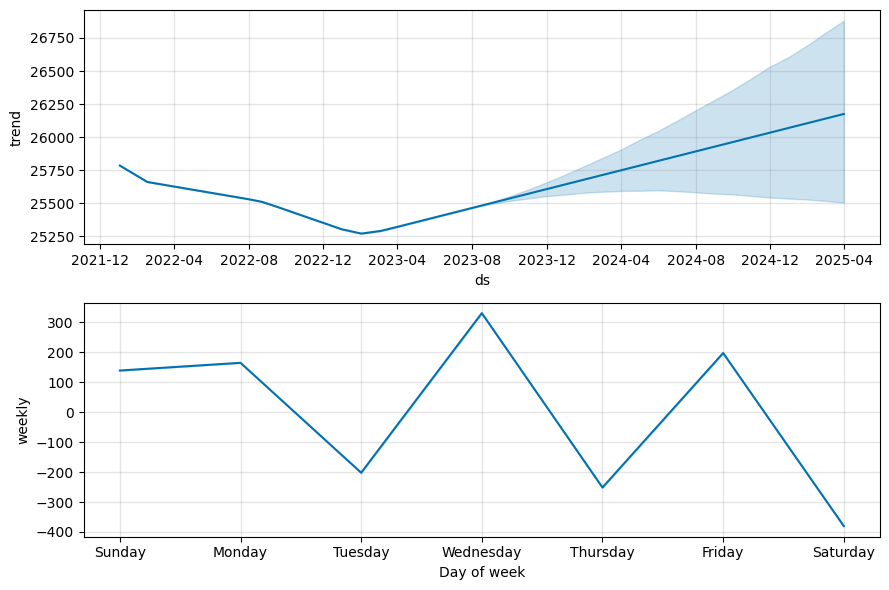

In [49]:
# plot predictions
model.plot_components(forecast)
plt.show()

#### Analysis

On the top graph of the result there is a solid blue line that represents the actual values. The lighter blue shaded area represents the margin of error accounted for in predictions. Our model predicted the remaininig dates in the test set and out till April of 2025. 

The dates closer to the split point has much less margin of error and it spreads out significantly the further ahead it goes. The further from the data we have, the less accurate the predictions will be. On the test set portion from August 8th, 2023, to December 31st, 2024, the model predicted it fairly well. Especially the points to the end of 2023 did really well. 

The bottom graph represents the day of the week with the most sales on average. Its clear that mid-week (Wednesday) and the end of the week (Friday) expect to have more sales than the rest of the week. For the weekends, it's harder to interpret because the seperation in the graph. But we can see that the massive dip in Saturday sales is recovered by Monday, indicating the possibility some of the dealerships are closed on the weekends.